# RNN Overview
This notebook predicts self-propelled particles with a basic RNN network to serve as the baseline. The performance is measured through several different means: (1) visual inspection of the predicted swarm behavior through an animation (2) visual inspection of the predicted and actual swarm behavior on the same plot (3) error bar plot for each agent (4) proper orthogonal decomposition (POD) to compare the different modes

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
import matplotlib
import time
import sys
import math
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
import time
import csv
from IPython.display import display
from sklearn.model_selection import train_test_split


# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
############## READING CSV ################
# read csv file into position and velocity lists
file_name = '/content/drive/My Drive/Sp2020/CS522/Final Project/Datasets/self_propelled_particles/swarm_03242020_3000steps.csv'
my_data = []
with open(file_name) as csvDataFile:
  csvReader = csv.reader(csvDataFile)
  for row in csvReader:
    my_data.append(row)
pos_from_file = []
vel_from_file =[]
pos_line = []
vel_line = []

for i in range(len(my_data)):
  for j in range(int(len(my_data[0])/2)):
    try:
      pos_line_str = my_data[i][j*2].lstrip('[').rstrip(']').split()
      vel_line_str = my_data[i][j*2+1].lstrip('[').rstrip(']').split()
    except:
      pass
    pos_line.append([float(pos_line_str[0]), float(pos_line_str[1])])
    vel_line.append([float(vel_line_str[0]), float(vel_line_str[1])])
  pos_from_file.append(pos_line)
  vel_from_file.append(vel_line)
  pos_line = []
  vel_line = []

In [0]:
############ REPLAYING FILES ############
print("Number of time steps: ", len(pos_from_file))
anim_lst = pos_from_file.copy()
# Animating a single agent, assuming agents live on a 2D plane
# initializing animation parameters
fig = plt.figure()
ax = plt.axes(xlim=(0,10),ylim=(0,10))

anim_lst = np.array(anim_lst)
x = anim_lst[:,:,0]
y = anim_lst[:,:,1]
d, = ax.plot(x[0],y[0], c='0.3',marker='.',linestyle='None')
'''
# dynamically plotting
out=display(fig, display_id=True)
anim_len = len(anim_lst)
for i in range(anim_len):
  d.set_data(x[i],y[i])
  out.update(fig)
  time.sleep(0.005)
  plt.savefig('/content/swarm_noise_img/swarm'+str(i)+'.jpg')
'''

# embedding animation, problem is that embedding size is limited
anim_lst = anim_lst.tolist()
def animate(i):
  try:
    dots = anim_lst[0][:]
    d.set_data([dot[0] for dot in dots],[dot[1] for dot in dots])
    anim_lst.pop(0)
    return d,
  except:
    "done"
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
# anim.save('training_1000steps.mp4',writer=animation.FFMpegWriter(fps=10))
rc('animation', html='jshtml')
anim


In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
DATA_LEN = len(pos_from_file)
HEAD_TRUNCATION = 500
MAX_ITER = DATA_LEN - HEAD_TRUNCATION
NO_AGENT = 32
TEST_SIZE = 0.8
input_size = NO_AGENT*4

pos_input = np.array(pos_from_file[HEAD_TRUNCATION:DATA_LEN])
pos_input = np.reshape(pos_input,[MAX_ITER, -1])
vel_input = np.array(vel_from_file[HEAD_TRUNCATION:DATA_LEN])
vel_input = np.reshape(vel_input,[MAX_ITER, -1])

pos_train_data, pos_test_data, vel_train_data, vel_test_data = train_test_split(pos_input,vel_input,test_size=TEST_SIZE, shuffle=False)

train_data = np.concatenate((pos_train_data, vel_train_data),axis=1)
test_data = pos_test_data

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1,input_size)
print("train data size: ",train_data_normalized.size())
print("test data size: ", len(test_data))

train data size:  torch.Size([500, 128])
test data size:  2000


In [0]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 5
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
# this sequence looks like, a list of tuples, which consist of data(list of data of window size) and label(next prediction)
print("train seq shape: ", len(train_inout_seq), ", 2, ", train_inout_seq[0][1].size())

train seq shape:  495 , 2,  torch.Size([1, 128])


In [0]:
class fcRNN(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_layers):
    super(fcRNN, self).__init__()
    # Write your code here
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, nonlinearity='relu')
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    # Write your code here
    x = x.view(len(x) ,1, -1)
    #print(x.size())
    #print(self.hidden.size())
    h0 = torch.zeros(self.n_layers, 1, self.hidden_dim).requires_grad_().to(device)
    out, hidden = self.rnn(x, h0.detach())
    out = out.view(-1, self.hidden_dim)
    out = self.fc(out)
    return out[-1]

In [0]:

LOAD_CHECKPOINT_PATH = '/content/drive/My Drive/Sp2020/CS522/Final Project/Codes/RNN_long.pth'
checkpoint = torch.load(LOAD_CHECKPOINT_PATH)
model = checkpoint['model']
#loss = checkpoint['loss']
'''
model = fcRNN(input_size, 200, input_size,1)
model.to(device)
'''
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

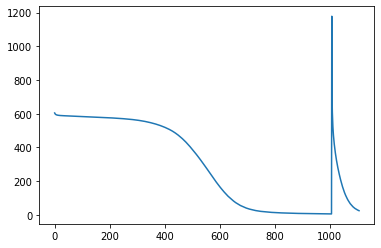

In [0]:
plt.plot(loss)

In [0]:
########## Training RNN ##########
loss = []
epochs = 100
CHECKPOINT_PATH = "/content/drive/My Drive/Sp2020/CS522/Final Project/Codes/RNN_long"
for i in range(epochs):
    running_loss = 0
    for seq, labels in train_inout_seq:
        seq.to(device)
        labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred.view(1,len(y_pred)), labels)
        single_loss.backward()
        optimizer.step()
        running_loss += single_loss.item()
    
    loss.append(running_loss)
    if i%5 == 0:
        print(f'epoch: {i:3} loss: {running_loss:10.8f}')
        if i%25 == 0:
          torch.save({'model': model,
                      'loss': loss
                        }, CHECKPOINT_PATH+".pth")
print(f'epoch: {i:3} loss: {running_loss:10.10f}')
torch.save({'model': model,
            'loss': loss}, CHECKPOINT_PATH+".pth")

epoch:   0 loss: 169.46677960


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type fcRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:   5 loss: 6.09148713
epoch:  10 loss: 3.93281358
epoch:  15 loss: 3.09704752
epoch:  20 loss: 2.64934741
epoch:  25 loss: 2.38236342
epoch:  30 loss: 2.21042206
epoch:  35 loss: 2.09221240
epoch:  40 loss: 2.00612026
epoch:  45 loss: 1.94084485
epoch:  50 loss: 1.88951408
epoch:  55 loss: 1.84766612
epoch:  60 loss: 1.81250286
epoch:  65 loss: 1.78219196
epoch:  70 loss: 1.75545219
epoch:  75 loss: 1.73169377
epoch:  80 loss: 1.71029819
epoch:  85 loss: 1.69084974
epoch:  90 loss: 1.67307772
epoch:  95 loss: 1.65670717
epoch:  99 loss: 1.6444857403


In [0]:
########## Predicting with RNN ##########

fut_pred = len(pos_test_data)
#fut_pred = len(pos_train_data)-train_window
test_inputs = train_data_normalized[-train_window:].tolist()
#test_inputs = train_data_normalized[0:train_window].tolist()
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).detach().numpy())

# only keeps predicted values
# test_inputs = test_inputs[-fut_pred:]
actual_predictions = scaler.inverse_transform(test_inputs)

# discarding velocity information
actual_predictions = actual_predictions[:,0:int(input_size/2)]
actual_predictions = np.reshape(actual_predictions, [fut_pred+train_window,int(input_size/4),2])

print(len(actual_predictions))
print('last step: ', np.reshape(pos_train_data[len(pos_train_data)-1], [32,2])[0])
print('prediction: ', actual_predictions[0][0])
print('ground truth: ', np.reshape(pos_test_data[0], [32,2])[0])

2005
last step:  [2.94441051 5.14202433]
prediction:  [3.03102726 5.52960957]
ground truth:  [2.93505233 5.042659  ]


In [0]:
############ REPLAYING FILES ############
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=10, label='Prediction')
red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='Ground Truth')
plt.legend(handles=[blue_dot, red_dot])

actual_predictions = np.array(actual_predictions)
pred_len = len(actual_predictions)
print("Predicted number of time steps: ", pred_len)

#ground_truth = np.reshape(pos_test_data, [len(pos_test_data), 32,2])
gt = np.concatenate((pos_train_data[-train_window:], pos_test_data),axis=0)
ground_truth = np.reshape(gt,  [pred_len, 32,2])
'''
x = actual_predictions[:,:,0]
y = actual_predictions[:,:,1]
x_gt = ground_truth[:,:,0]
y_gt = ground_truth[:,:,1]
'''
x = gt_recon[:,:,0]
y = gt_recon[:,:,1]
x_gt = pred_recon[:,:,0]
y_gt = pred_recon[:,:,1]

x_min = np.amin(x)-2
x_max = np.amax(x)+2
y_min = np.amin(y)-2
y_max = np.amax(y)+2

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max))



# initialize animation parameters
gg = [Line2D([x_gt[0][0], x[0][0]],[y_gt[0][0], y[0][0]]) for i in range(32)]
for j in range(32):
  gg[j], = ax.plot([x_gt[0][j], x[0][j]],[y_gt[0][j], y[0][j]], c='mediumspringgreen',marker='.')
d, = ax.plot(x[0],y[0], c='blue',marker='.',linestyle='None')
e, = ax.plot(x_gt[0],y_gt[0], c='red',marker='.',linestyle='None')

def animate(i):
    plt.legend(handles=[blue_dot, red_dot])
    for j in range(32):
      gg[j].set_data([x_gt[i][j], x[i][j]],[y_gt[i][j], y[i][j]])
    d.set_data(x[i],y[i])
    e.set_data(x_gt[i],y_gt[i])
    return e, d,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=500, interval=20, blit=True)
# anim.save('cool_vid.mp4',writer=animation.FFMpegWriter(fps=20))
rc('animation', html='jshtml')
anim


In [0]:
############ Animate Errors #############

# Calculating euclidean distances between each point
diff = np.abs(actual_predictions - ground_truth)
diff = np.sqrt(np.power(diff[:,:,0],2)+np.power(diff[:,:,1],2))
print(diff.shape)

def barlist(n): 
    return [1/float(n*k) for k in range(1,6)]

fig=plt.figure()
fig.set_size_inches(10, 5)
x= range(1,33)
ax = plt.axes(ylim=(0,0.8))
barcollection = plt.bar(x ,diff[0])

def animate(a):
    y=diff[a]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])


anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=1000,
                            interval=100)


anim.save('error_barplot.mp4',writer=animation.FFMpegWriter(fps=10))
rc('animation', html='jshtml')
anim

In [0]:
def calculate_POD_basis(snapshots):
    '''
    :param snapshots: snapshots imported as 2-D array of size (# of elements, # of snapshots)

    :return:
    '''
    n_time = len(snapshots)
    snapshots = np.transpose(snapshots)
    # singular value decomposition
    U,S,V = np.linalg.svd(snapshots)

    U = U.real
    S = S.real
    V = V.real

    I = np.argsort(S)[::-1]
    S = S[I]
    U = U[:, I]
    '''
    pod_basis = create_basis(U, S, energy=0.65)
    
    '''
    pod_basis = U[:,0:2]
    pod_basis = np.reshape(pod_basis, [-1,pod_basis.shape[1]])
    

    _,m = pod_basis.shape
    print('pod basis shape: ', pod_basis.shape, 'm: ',m)
    sing = np.diag(S[0:m])
    tail = np.zeros([m,n_time-m])
    mid = np.concatenate((sing, tail), axis=1)
    
    recon = pod_basis @ mid @ V
    return U, S, V, np.transpose(recon)


def create_basis(V, D, energy):
    '''
    Creates basis functions for POD using SVD decomposition
    :param V: eigenvectors of covariance matrix
    :param D: diagonal matrix with eigenvalues of covariance matrix
    :param energy: parameter for how much "energy" is desired to be capture in POD basis (usually 95%+)
    :return: POD basis phi
    '''
    cum_sum = 0
    total_sum = sum(D).real
    m = 0  # Calculate number of POD bases that will be needed

    for i in range(len(D)):
        cum_sum += D[i].real
        percentage_energy = cum_sum/total_sum
        if percentage_energy < energy:
            m = i
        else:
            m = i
            break

    # Create new matrix based on POD values at each of the sub domains given by value in regionDictionary
    # phi is (n, m) for n = number of elements in mesh, m = number of elements in POD
    phi = V[:, 0:m + 1]
    return phi.real


pod basis shape:  (64, 2) m:  2


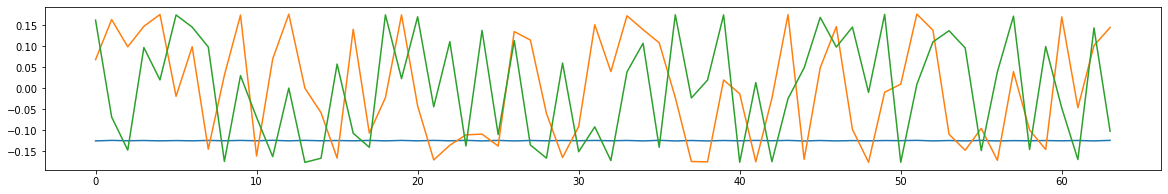

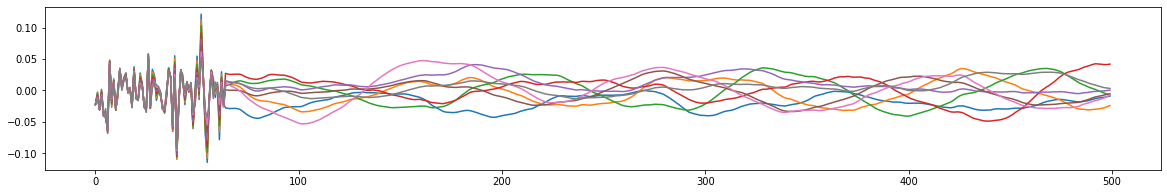

In [0]:
U,S,V,gt_recon = calculate_POD_basis(gt)
'''
pred_recon = calculate_POD_basis(np.reshape(actual_predictions, [len(actual_predictions), -1]))

gt_recon = np.reshape(np.array(gt_recon), [len(gt),-1,2])
pred_recon = np.reshape(np.array(pred_recon), [len(gt),-1,2])
'''
#plt.plot(S, marker ='.',linestyle="None")
fig = plt.figure()
fig.set_size_inches(20, 3)
plt.plot(U[:,0])
plt.plot(U[:,1])
plt.plot(U[:,2])
#plt.plot(U[:,63])
fig = plt.figure()
fig.set_size_inches(20, 3)
plt.plot(V[0:500,0])
plt.plot(V[0:500,1])
plt.plot(V[0:500,2])
plt.plot(V[0:500,3])
plt.plot(V[0:500,4])
plt.plot(V[0:500,5])
plt.plot(V[0:500,6])
plt.plot(V[0:500,7])
